In [341]:
# CS194-26 (CS294-26): Project 1 starter Python code

# these are just some suggested libraries
# instead of scikit-image you could use matplotlib and opencv to read, write, and display images

import numpy as np
import skimage as sk
import skimage.io as skio
import time

In [342]:
# my libraries
import cs194utils

Start processing image data/icon.tif


/Users/david/dev/cs194/cs194-venv/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Displacement Vector (17, 41) Best score 0.7776463198555756
Displacement Vector (23, 89) Best score 0.6028159637156403


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


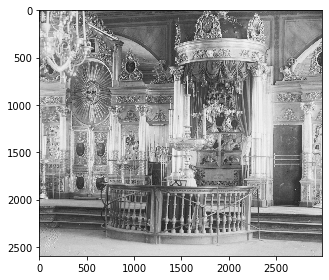

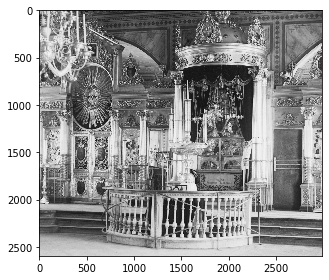

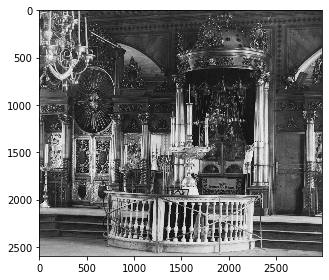

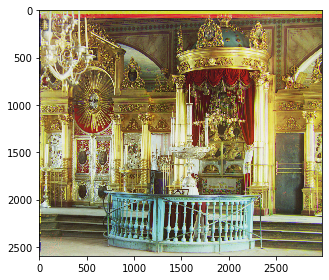

End processing image data/icon.tif
--- 24.95639204978943 seconds ---


In [358]:
def read_image(imname):
    # read in the image
    im = skio.imread(imname)
    
    # convert to double (might want to do this later on to save memory)    
    im = sk.img_as_float(im)

    return im

def write_image(im, imname):
    skio.imsave(imname, im)

def show_image(im):
    # display the image
    skio.imshow(im)
    skio.show()
    
def align_low_resolution(to_be_aligned, reference):    
    best_score = float("-inf")
    best_aligned = None 
    best_x, best_y = -1, -1
                                    
    for x in range(-16, 16):
        for y in range(-16, 16):
            shifted = np.roll(to_be_aligned, x, axis=1)
            shifted = np.roll(shifted, y, axis=0)

            score = metric_score_ncc(shifted, reference)
            
            if score > best_score:
                best_score = score
                best_aligned = shifted
                best_x, best_y = x, y
        
    print("Displacement Vector", (best_x, best_y), "Best score", best_score)
    return best_aligned

def align_high_resolution(to_be_aligned, reference):
    recursive_level = 0
    best_aligned = None
    
    def helper(to_be_aligned, reference):
        nonlocal recursive_level
        nonlocal best_aligned
        recursive_level += 1

        height, width = to_be_aligned.shape
        
        resized_best_shifted = None
        if recursive_level < 6:
            to_be_aligned_rescaled = sk.transform.rescale(to_be_aligned, 0.5)
            reference_rescaled = sk.transform.rescale(reference, 0.5)
            resized_best_shifted = helper(to_be_aligned_rescaled, reference_rescaled)
        
        best_score = float("-inf")
        best_x, best_y = -1, -1
        for x in range(-3, 3):
            for y in range(-3, 3):
                xx, yy = x, y
                if resized_best_shifted:
                    xx = resized_best_shifted[0] * 2 + xx
                    yy = resized_best_shifted[1] * 2 + yy
                    
                shifted = np.roll(to_be_aligned, xx, axis=1)
                shifted = np.roll(shifted, yy, axis=0)

                score = metric_score_ncc(shifted, reference)

                if score > best_score:
                    best_score = score
                    best_x, best_y = xx, yy
                    best_aligned = shifted
        
        return (best_x, best_y)
    
    best_shifted = helper(to_be_aligned, reference)
    
    print("Displacement Vector", best_shifted, "Best score", metric_score_ncc(best_aligned, reference))
    return best_aligned
    

def metric_score_ssd(image1, image2):
    return np.sum((image1 - image2)**2)

def metric_score_ncc(image1, image2):
    im1 = (image1 - np.mean(image1)) / np.std(image1, ddof=1)
    im2 = (image2 - np.mean(image2)) / np.std(image2, ddof=1)
    return np.sum(im1*im2) / (im1.shape[0] * im1.shape[1] - 1)

def produce_color(imname, align):
    im = read_image(imname)
    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(np.int)

    # separate color channels
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]

    # David crops images
    height, width = b.shape
    #smaller images
    b = cs194utils.crop(b, int(height*0.1), int(height*0.9), int(width*0.1), int(width*0.9))
    g = cs194utils.crop(g, int(height*0.1), int(height*0.9), int(width*0.1), int(width*0.9))
    r = cs194utils.crop(r, int(height*0.1), int(height*0.9), int(width*0.1), int(width*0.9))
    
    #b = cs194utils.crop(b, 200, height-200, 200, width-200)
    #g = cs194utils.crop(g, 200, height-200, 200, width-200)
    #r = cs194utils.crop(r, 200, height-200, 200, width-200)
    # align the images
    ag = align(g, b)
    
    ar = align(r, b)
    
    # create a color image
    im_out = np.dstack([ar, ag, b])
    return im_out, r, g, b

def main(imin, imout, align):
    IMAGE_NAME_IN  = imin
    IMAGE_NAME_OUT = imout
    print("Start processing image", IMAGE_NAME_IN)
    im_out, r, g, b = produce_color(IMAGE_NAME_IN, align)
    write_image(im_out, IMAGE_NAME_OUT)
    show_image(r)
    show_image(g)
    show_image(b)
    show_image(im_out)
    print("End processing image", IMAGE_NAME_IN)

start_time = time.time()
main('data/icon.tif', 'out/icon.jpg', align_high_resolution)
print("--- %s seconds ---" % (time.time() - start_time))

In [3]:
import time

# list files
import glob, os

# read, write, process images
import numpy as np
import skimage as sk
import skimage.transform
import skimage.io as skio


def read_image(im_name):
    # read in the image
    im = skio.imread(im_name)
    
    # convert to double (might want to do this later on to save memory)    
    im = sk.img_as_float(im)

    return im

def write_image(im, im_name):
    skio.imsave(im_name, im)

def metric_score_ncc(image1, image2):
    im1 = (image1 - np.mean(image1)) / np.std(image1, ddof=1)
    im2 = (image2 - np.mean(image2)) / np.std(image2, ddof=1)
    return np.sum(im1*im2) / (im1.shape[0] * im1.shape[1] - 1)

def align_low_resolution(to_be_aligned, reference, metric):    
    best_score = float("-inf")
    best_aligned = None 
    best_x, best_y = -1, -1
                                    
    for x in range(-16, 16):
        for y in range(-16, 16):
            shifted = np.roll(to_be_aligned, x, axis=1)
            shifted = np.roll(shifted, y, axis=0)

            score = metric(shifted, reference)
            
            if score > best_score:
                best_score = score
                best_aligned = shifted
                best_x, best_y = x, y
        
    return best_aligned, best_x, best_y

def align_high_resolution(to_be_aligned, reference, metric):
    """
    def helper(to_be_aligned, reference):
        nonlocal recursive_level
        nonlocal best_aligned
        recursive_level += 1

        height, width = to_be_aligned.shape
        
        resized_best_shifted = None
        if recursive_level < 6:
            to_be_aligned_rescaled = sk.transform.rescale(to_be_aligned, 0.5)
            reference_rescaled = sk.transform.rescale(reference, 0.5)
            resized_best_shifted = helper(to_be_aligned_rescaled, reference_rescaled)
        

        best_score = float("-inf")
        best_x, best_y = -1, -1
        for x in range(-5, 5):
            for y in range(-5, 5):
                xx, yy = x, y
                if resized_best_shifted:
                    xx = resized_best_shifted[0] * 2 + xx
                    yy = resized_best_shifted[1] * 2 + yy
                    
                shifted = np.roll(to_be_aligned, xx, axis=1)
                shifted = np.roll(shifted, yy, axis=0)

                score = metric_score_ncc(shifted, reference)

                if score > best_score:
                    best_score = score
                    best_x, best_y = xx, yy
                    best_aligned = shifted
        return (best_x, best_y)
    
    recursive_level = 0
    best_aligned = None
    best_shifted = helper(to_be_aligned, reference)
    
    return best_aligned, best_shifted[0], best_shifted[1]
    """
    
    best_aligned = None
    previous_best_x, previous_best_y = -1, -1
    for scale in reversed(range(6)):
        to_be_aligned_scaled = sk.transform.rescale(to_be_aligned, (1/2)**scale)
        reference_scaled = sk.transform.rescale(reference, (1/2)**scale)
        
        best_score = float("-inf")
        best_x, best_y = -1, -1
        
        for x in range(-5, 5):
            for y in range(-5, 5):
                xx, yy = x, y
                if scale != 5:
                    xx = previous_best_x * 2 + xx
                    yy = previous_best_y * 2 + yy
                    
                shifted = np.roll(to_be_aligned_scaled, xx, axis=1)
                shifted = np.roll(shifted, yy, axis=0)

                score = metric_score_ncc(shifted, reference_scaled)

                if score > best_score:
                    best_score = score
                    best_x, best_y = xx, yy
                    best_aligned = shifted
        previous_best_x, previous_best_y = best_x, best_y
        
    return best_aligned, previous_best_x, previous_best_y
    
    
def produce(image_file_path, align_func, metric):
    im = read_image(image_file_path)
    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(np.int)

    # separate color channels
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]

    # David crops images
    height, width = b.shape
    b = b[int(height*0.1):int(height*0.9), int(width*0.1):int(width*0.9)]
    g = g[int(height*0.1):int(height*0.9), int(width*0.1):int(width*0.9)]
    r = r[int(height*0.1):int(height*0.9), int(width*0.1):int(width*0.9)]
    
    # align the images
    ag, gx, gy = align_func(g, b, metric)
    ar, rx, ry = align_func(r, b, metric)
    
    # create a color image
    im_out = np.dstack([ar, ag, b])
    
    return im_out, (gx, gy), (rx, ry) 

def main():
    for file in os.listdir("data"):
        # read images with low resolution
        if file.endswith(".jpg"):
            im_in_path = os.path.join("data", file)
            im_out_path = "test/" + file
            
            print(im_out_path)
            start_time = time.time()
            im_out, (gx, gy), (rx, ry) = produce(im_in_path, align_low_resolution, metric_score_ncc)
            print("--- %s seconds ---" % (time.time() - start_time))
            
            f = open(im_out_path + ".displacement.txt", "w")
            f.write("green:" + str((gx, gy)) + ",")
            f.write("red:" + str((rx, ry)))
            f.close()
            write_image(im_out, im_out_path)
            
        # read images with high resolution
        elif file.endswith(".tif"):
            im_in_path = os.path.join("data", file)
            im_out_path = "test/" + file[:-len(".tif")] + ".jpg"
            
            print(im_out_path)
            start_time = time.time()
            im_out, (gx, gy), (rx, ry) = produce(im_in_path, align_high_resolution, metric_score_ncc)
            print("--- %s seconds ---" % (time.time() - start_time))
            
            f = open(im_out_path + ".displacement.txt", "w")
            f.write("green:" + str((gx, gy)) + ",")
            f.write("red:" + str((rx, ry)))
            f.close()
            write_image(im_out, im_out_path)
            
main()

test/workshop.jpg


/Users/david/dev/cs194/cs194-venv/lib/python3.7/site-packages/ipykernel_launcher.py:125: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


--- 54.54407978057861 seconds ---


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


test/emir.jpg
--- 53.34170889854431 seconds ---


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


test/monastery.jpg


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


--- 1.8753342628479004 seconds ---
test/church.jpg


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


--- 51.79529094696045 seconds ---
test/three_generations.jpg
--- 54.71723484992981 seconds ---


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


test/melons.jpg


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


--- 54.61372685432434 seconds ---
test/onion_church.jpg
--- 54.49142599105835 seconds ---


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


test/train.jpg
--- 53.98370695114136 seconds ---


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


test/tobolsk.jpg


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


--- 1.9577219486236572 seconds ---
test/icon.jpg


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


--- 54.768463134765625 seconds ---
test/cathedral.jpg


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


--- 1.9567840099334717 seconds ---
test/self_portrait.jpg
--- 55.96337580680847 seconds ---


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


test/harvesters.jpg
--- 53.84022784233093 seconds ---


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


test/lady.jpg
--- 54.79028677940369 seconds ---


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
